In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE

data = pd.read_csv('pseudodata_præoperation.csv')

# # #make pd to np
X = data.to_numpy()
y = np.random.choice([0, 1], size=len(data))

X = StandardScaler().fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_tensor.numpy(), y_tensor.numpy())
X_resampled = torch.tensor(X_resampled, dtype=torch.float32)
y_resampled = torch.tensor(y_resampled, dtype=torch.float32)

# Create a dataset
dataset = TensorDataset(X_tensor, y_tensor)

# Split data into holdout set and remaining set
indices = np.arange(len(dataset))
np.random.seed(42)
np.random.shuffle(indices)
holdout_indices = indices[:500]
remaining_indices = indices[500:]

holdout_set = Subset(dataset, holdout_indices)
remaining_set = Subset(dataset, remaining_indices)

# Define the ANN model with L2 regularization
class DeepANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(DeepANNModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_layers = nn.ModuleList([
            nn.Linear(input_dim if i == 0 else hidden_dims[i-1], hidden_dim)
            for i, hidden_dim in enumerate(hidden_dims)
        ])
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        for layer in self.hidden_layers:
            x = self.relu(layer(x))
        x = self.sigmoid(self.output_layer(x))
        return x

input_dim = 575
hidden_dims = [128,64]
output_dim = 2

# Function to train and evaluate the model with L2 regularization
def train_and_evaluate_model(train_loader, val_loader, input_dim, hidden_dim, output_dim, num_epochs=10, lr=0.01, weight_decay=1e-5):
    model = DeepANNModel(input_dim, hidden_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    # Evaluate on validation set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    return accuracy, model

# Outer 10-Fold Cross-Validation
outer_kf = KFold(n_splits=2, shuffle=True, random_state=42)
outer_accuracies = []
best_model_params = None
best_outer_accuracy = 0

for outer_train_index, outer_test_index in outer_kf.split(remaining_indices):
    outer_train_subset = Subset(remaining_set, outer_train_index)
    outer_test_subset = Subset(remaining_set, outer_test_index)
    
    # Inner 10-Fold Cross-Validation
    inner_kf = KFold(n_splits=2, shuffle=True, random_state=42)
    inner_accuracies = []

    for inner_train_index, inner_val_index in inner_kf.split(outer_train_index):
        inner_train_indices = np.array(outer_train_index)[inner_train_index]
        inner_val_indices = np.array(outer_train_index)[inner_val_index]
        
        inner_train_subset = Subset(remaining_set, inner_train_indices)
        inner_val_subset = Subset(remaining_set, inner_val_indices)
        
        train_loader = DataLoader(inner_train_subset, batch_size=64, shuffle=True)
        val_loader = DataLoader(inner_val_subset, batch_size=64, shuffle=False)
        
        accuracy, model = train_and_evaluate_model(train_loader, val_loader, input_dim, hidden_dims, output_dim)
        inner_accuracies.append(accuracy)
        print(f'Inner Fold Accuracy: {accuracy * 100:.2f}%')

    mean_inner_accuracy = np.mean(inner_accuracies)
    print(f'Outer Fold Mean Inner Accuracy: {mean_inner_accuracy * 100:.2f}%')

    train_loader = DataLoader(outer_train_subset, batch_size=64, shuffle=True)
    test_loader = DataLoader(outer_test_subset, batch_size=64, shuffle=False)
    
    outer_accuracy, outer_model = train_and_evaluate_model(train_loader, test_loader, input_dim, hidden_dims, output_dim)
    outer_accuracies.append(outer_accuracy)
    print(f'Outer Fold Accuracy: {outer_accuracy * 100:.2f}%')

    if outer_accuracy > best_outer_accuracy:
        best_outer_accuracy = outer_accuracy
        best_model_params = outer_model.state_dict()

print(f'Mean Outer Accuracy: {np.mean(outer_accuracies) * 100:.2f}%')
print('Best model parameters:', best_model_params)

# Evaluate the final model on the holdout set
final_model = DeepANNModel(input_dim, hidden_dims, output_dim)
final_model.load_state_dict(best_model_params)
train_loader = DataLoader(remaining_set, batch_size=64, shuffle=True)
holdout_loader = DataLoader(holdout_set, batch_size=64, shuffle=False)

import torch
from sklearn.metrics import precision_score, recall_score

def evaluate_holdout(model, holdout_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in holdout_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    return precision, recall

# Example usage
holdout_precision, holdout_recall = evaluate_holdout(final_model, holdout_loader)
print(f'Holdout Set Precision: {holdout_precision * 100:.2f}%')
print(f'Holdout Set Recall: {holdout_recall * 100:.2f}%')



Inner Fold Accuracy: 49.03%
Inner Fold Accuracy: 53.06%
Outer Fold Mean Inner Accuracy: 51.04%
Outer Fold Accuracy: 48.77%
Inner Fold Accuracy: 44.64%
Inner Fold Accuracy: 48.73%
Outer Fold Mean Inner Accuracy: 46.69%
Outer Fold Accuracy: 50.89%
Mean Outer Accuracy: 49.83%
Best model parameters: OrderedDict({'hidden_layers.0.weight': tensor([[-0.0138,  0.0305,  0.0051,  ...,  0.0293,  0.0022, -0.0150],
        [ 0.0095, -0.0010, -0.0061,  ...,  0.0014,  0.0376,  0.0207],
        [ 0.0045, -0.0320,  0.0089,  ...,  0.0050,  0.0387,  0.0084],
        ...,
        [ 0.0161, -0.0161, -0.0076,  ..., -0.0323, -0.0165,  0.0308],
        [ 0.0155,  0.0120, -0.0122,  ...,  0.0195,  0.0349, -0.0402],
        [-0.0280,  0.0044, -0.0012,  ...,  0.0116, -0.0196, -0.0101]]), 'hidden_layers.0.bias': tensor([-0.0310, -0.0342, -0.0041,  0.0081,  0.0353,  0.0243, -0.0147, -0.0115,
        -0.0412,  0.0405,  0.0401, -0.0223, -0.0274, -0.0072,  0.0231,  0.0215,
         0.0126, -0.0195, -0.0388, -0.0075,  

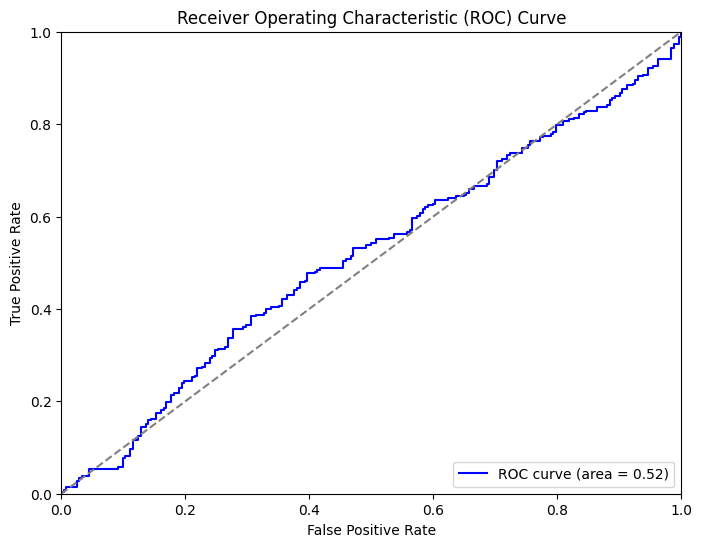

AUC Score: 0.52


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def evaluate_roc_auc(model, holdout_loader):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for images, labels in holdout_loader:
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Assuming binary classification
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    auc_score = roc_auc_score(all_labels, all_probs)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return auc_score

# Example usage
auc_score = evaluate_roc_auc(final_model, holdout_loader)
print(f'AUC Score: {auc_score:.2f}')


Inner Fold Accuracy: 50.41%
Inner Fold Accuracy: 45.04%
Inner Fold Accuracy: 50.00%
Inner Fold Accuracy: 45.04%
Inner Fold Accuracy: 51.24%
Inner Fold Accuracy: 43.39%
Inner Fold Accuracy: 54.77%
Inner Fold Accuracy: 48.55%
Inner Fold Accuracy: 55.60%
Inner Fold Accuracy: 51.04%
Outer Fold Mean Inner Accuracy: 49.51%
Outer Fold Accuracy: 49.81%
Inner Fold Accuracy: 45.45%
Inner Fold Accuracy: 53.72%
Inner Fold Accuracy: 48.35%
Inner Fold Accuracy: 53.31%
Inner Fold Accuracy: 48.76%
Inner Fold Accuracy: 48.76%
Inner Fold Accuracy: 47.30%
Inner Fold Accuracy: 57.68%
Inner Fold Accuracy: 53.11%
Inner Fold Accuracy: 56.02%
Outer Fold Mean Inner Accuracy: 51.25%
Outer Fold Accuracy: 46.47%
Inner Fold Accuracy: 46.28%
Inner Fold Accuracy: 52.07%
Inner Fold Accuracy: 47.93%
Inner Fold Accuracy: 46.28%
Inner Fold Accuracy: 44.63%
Inner Fold Accuracy: 48.76%
Inner Fold Accuracy: 46.47%
Inner Fold Accuracy: 53.11%
Inner Fold Accuracy: 55.19%
Inner Fold Accuracy: 44.81%
Outer Fold Mean Inner Accu

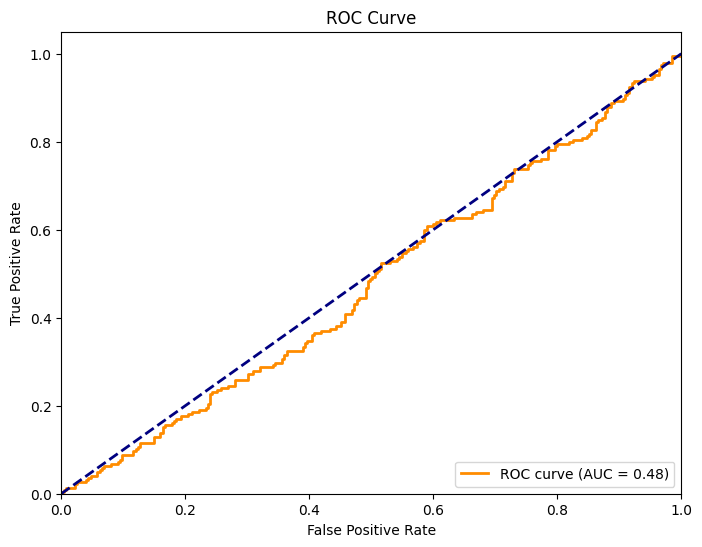

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, roc_curve, auc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('pseudodata_præoperation.csv')

# Convert data to numpy arrays
X = data.to_numpy()
y = np.random.choice([0, 1], size=len(data))

X = StandardScaler().fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
  # Note: use float32 for BCEWithLogitsLoss

# Create a dataset
dataset = TensorDataset(X_tensor, y_tensor)

# Split data into holdout set and remaining set
indices = np.arange(len(dataset))
np.random.seed(42)
np.random.shuffle(indices)
holdout_indices = indices[:500]
remaining_indices = indices[500:]

holdout_set = Subset(dataset, holdout_indices)
remaining_set = Subset(dataset, remaining_indices)

# Define the deep ANN model with L2 regularization
class DeepANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super(DeepANNModel, self).__init__()
        self.hidden_layers = nn.ModuleList([
            nn.Linear(input_dim if i == 0 else hidden_dims[i-1], hidden_dim)
            for i, hidden_dim in enumerate(hidden_dims)
        ])
        self.output_layer = nn.Linear(hidden_dims[-1], 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        for layer in self.hidden_layers:
            x = self.relu(layer(x))
        x = self.output_layer(x)
        return x

input_dim = 575
hidden_dims = [128, 64]

# Function to train and evaluate the model with L2 regularization
def train_and_evaluate_model(train_loader, val_loader, input_dim, hidden_dims, num_epochs=10, lr=0.01, weight_decay=1e-5):
    model = DeepANNModel(input_dim, hidden_dims)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            # Forward pass
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    # Evaluate on validation set
    model.eval()
    correct = 0
    total = 0
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images).squeeze()
            predicted = torch.round(torch.sigmoid(outputs))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_outputs.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / total
    return accuracy, model

# Outer 10-Fold Cross-Validation
outer_kf = KFold(n_splits=10, shuffle=True, random_state=42)
outer_accuracies = []
best_model_params = None
best_outer_accuracy = 0

for outer_train_index, outer_test_index in outer_kf.split(remaining_indices):
    outer_train_subset = Subset(remaining_set, outer_train_index)
    outer_test_subset = Subset(remaining_set, outer_test_index)
    
    # Inner 10-Fold Cross-Validation
    inner_kf = KFold(n_splits=10, shuffle=True, random_state=42)
    inner_accuracies = []

    for inner_train_index, inner_val_index in inner_kf.split(outer_train_index):
        inner_train_indices = np.array(outer_train_index)[inner_train_index]
        inner_val_indices = np.array(outer_train_index)[inner_val_index]
        
        inner_train_subset = Subset(remaining_set, inner_train_indices)
        inner_val_subset = Subset(remaining_set, inner_val_indices)
        
        train_loader = DataLoader(inner_train_subset, batch_size=64, shuffle=True)
        val_loader = DataLoader(inner_val_subset, batch_size=64, shuffle=False)
        
        accuracy, model = train_and_evaluate_model(train_loader, val_loader, input_dim, hidden_dims)
        inner_accuracies.append(accuracy)
        print(f'Inner Fold Accuracy: {accuracy * 100:.2f}%')

    mean_inner_accuracy = np.mean(inner_accuracies)
    print(f'Outer Fold Mean Inner Accuracy: {mean_inner_accuracy * 100:.2f}%')

    train_loader = DataLoader(outer_train_subset, batch_size=64, shuffle=True)
    test_loader = DataLoader(outer_test_subset, batch_size=64, shuffle=False)
    
    outer_accuracy, outer_model = train_and_evaluate_model(train_loader, test_loader, input_dim, hidden_dims)
    outer_accuracies.append(outer_accuracy)
    print(f'Outer Fold Accuracy: {outer_accuracy * 100:.2f}%')

    if outer_accuracy > best_outer_accuracy:
        best_outer_accuracy = outer_accuracy
        best_model_params = outer_model.state_dict()

print(f'Mean Outer Accuracy: {np.mean(outer_accuracies) * 100:.2f}%')
print('Best model parameters:', best_model_params)

# Evaluate the final model on the holdout set
final_model = DeepANNModel(input_dim, hidden_dims)
final_model.load_state_dict(best_model_params)
train_loader = DataLoader(remaining_set, batch_size=64, shuffle=True)
holdout_loader = DataLoader(holdout_set, batch_size=64, shuffle=False)

# Evaluate the final model on the holdout set
final_model.eval()
holdout_outputs = []
holdout_targets = []
with torch.no_grad():
    for inputs, labels in holdout_loader:
        outputs = final_model(inputs).squeeze()
        probabilities = torch.sigmoid(outputs)  # Get the probabilities for the positive class
        holdout_outputs.extend(probabilities.numpy())
        holdout_targets.extend(labels.numpy())

# Convert holdout outputs to binary predictions
holdout_predictions = np.round(holdout_outputs)

holdout_accuracy = accuracy_score(holdout_targets, holdout_predictions)
holdout_recall = recall_score(holdout_targets, holdout_predictions)
print(f'Holdout Set Accuracy: {holdout_accuracy * 100:.2f}%')
print(f'Holdout Set Recall: {holdout_recall * 100:.2f}%')

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(holdout_targets, holdout_outputs)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Load your dataset
data = pd.read_csv('pseudodata_præoperation.csv')

# Preprocess your data
X = data
y = np.random.choice([0, 1], size=len(data))

X = StandardScaler().fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Create a dataset
dataset = TensorDataset(X_tensor, y_tensor)

# Split data into holdout set and remaining set
indices = np.arange(len(dataset))
np.random.seed(42)
np.random.shuffle(indices)
holdout_indices = indices[:500]
remaining_indices = indices[500:]

holdout_set = Subset(dataset, holdout_indices)
remaining_set = Subset(dataset, remaining_indices)

# Define the ANN model
class DeepANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(DeepANNModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_layers = nn.ModuleList([
            nn.Linear(input_dim if i == 0 else hidden_dims[i-1], hidden_dim)
            for i, hidden_dim in enumerate(hidden_dims)
        ])
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        for layer in self.hidden_layers:
            x = self.relu(layer(x))
        x = self.sigmoid(self.output_layer(x))
        return x

# Function to train and evaluate the model with L2 regularization
def train_and_evaluate_model(train_loader, val_loader, input_dim, hidden_dims, output_dim, num_epochs=10, lr=0.01, weight_decay=1e-5):
    model = DeepANNModel(input_dim, hidden_dims, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    # Evaluate on validation set
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / total
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    
    return accuracy, precision, recall, model

# Function for grid search over different weight_decay values
def grid_search_weight_decay(train_set, outer_kf, inner_kf, input_dim, hidden_dims, output_dim, num_epochs=10, lr=0.01, weight_decay_values=[1e-5, 1e-4, 1e-3]):
    best_weight_decay = None
    best_outer_accuracy = 0
    best_outer_precision = 0
    best_outer_recall = 0
    
    for weight_decay in weight_decay_values:
        print(f'Grid search for weight_decay={weight_decay}')
        outer_accuracies = []
        outer_precisions = []
        outer_recalls = []
        
        for outer_train_index, outer_test_index in outer_kf.split(train_set):
            outer_train_subset = Subset(train_set, outer_train_index)
            outer_test_subset = Subset(train_set, outer_test_index)
            
            inner_accuracies = []
            inner_precisions = []
            inner_recalls = []
            
            for inner_train_index, inner_val_index in inner_kf.split(outer_train_subset):
                inner_train_subset = Subset(outer_train_subset, inner_train_index)
                inner_val_subset = Subset(outer_train_subset, inner_val_index)
                
                train_loader = DataLoader(inner_train_subset, batch_size=64, shuffle=True)
                val_loader = DataLoader(inner_val_subset, batch_size=64, shuffle=False)
                
                accuracy, _, _, _ = train_and_evaluate_model(train_loader, val_loader, input_dim, hidden_dims, output_dim, num_epochs=num_epochs, lr=lr, weight_decay=weight_decay)
                inner_accuracies.append(accuracy)
                print(f'  Inner Fold Accuracy: {accuracy * 100:.2f}%')
            
            mean_inner_accuracy = np.mean(inner_accuracies)
            print(f'  Mean Inner Accuracy: {mean_inner_accuracy * 100:.2f}%')
            
            train_loader = DataLoader(outer_train_subset, batch_size=64, shuffle=True)
            test_loader = DataLoader(outer_test_subset, batch_size=64, shuffle=False)
            
            outer_accuracy, outer_precision, outer_recall, _ = train_and_evaluate_model(train_loader, test_loader, input_dim, hidden_dims, output_dim, num_epochs=num_epochs, lr=lr, weight_decay=weight_decay)
            outer_accuracies.append(outer_accuracy)
            outer_precisions.append(outer_precision)
            outer_recalls.append(outer_recall)
            print(f'  Outer Fold Accuracy: {outer_accuracy * 100:.2f}%')
            print(f'  Outer Fold Precision: {outer_precision * 100:.2f}%')
            print(f'  Outer Fold Recall: {outer_recall * 100:.2f}%')
        
        mean_outer_accuracy = np.mean(outer_accuracies)
        mean_outer_precision = np.mean(outer_precisions)
        mean_outer_recall = np.mean(outer_recalls)
        print(f'Mean Outer Accuracy for weight_decay={weight_decay}: {mean_outer_accuracy * 100:.2f}%')
        print(f'Mean Outer Precision for weight_decay={weight_decay}: {mean_outer_precision * 100:.2f}%')
        print(f'Mean Outer Recall for weight_decay={weight_decay}: {mean_outer_recall * 100:.2f}%')
        
        if mean_outer_accuracy > best_outer_accuracy:
            best_outer_accuracy = mean_outer_accuracy
            best_outer_precision = mean_outer_precision
            best_outer_recall = mean_outer_recall
            best_weight_decay = weight_decay
    
    print(f'Best weight_decay: {best_weight_decay}, Best Mean Outer Accuracy: {best_outer_accuracy * 100:.2f}%')
    print(f'Best Mean Outer Precision: {best_outer_precision * 100:.2f}%')
    print(f'Best Mean Outer Recall: {best_outer_recall * 100:.2f}%')
    return best_weight_decay

# Outer 5-Fold Cross-Validation
outer_kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Inner 5-Fold Cross-Validation
inner_kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search over different weight_decay values
best_weight_decay = grid_search_weight_decay(remaining_set, outer_kf, inner_kf, input_dim=575, hidden_dims=[128, 64], output_dim=2, num_epochs=10, lr=0.01, weight_decay_values=[1e-5, 1e-4, 1e-3])

print(f'Best weight_decay found: {best_weight_decay}')

# Evaluate the final model on the holdout set with the best weight_decay
final_model = DeepANNModel(input_dim=575, hidden_dims=[128, 64], output_dim=2)
train_loader = DataLoader(remaining_set, batch_size=64, shuffle=True)
holdout_loader = DataLoader(holdout_set, batch_size=64, shuffle=False)

accuracy, precision, recall, _ = train_and_evaluate_model(train_loader, holdout_loader, input_dim=575, hidden_dims=[128, 64], output_dim=2, num_epochs=10, lr=0.01, weight_decay=best_weight_decay)

print(f'Holdout Set Accuracy: {accuracy * 100:.2f}%')
print(f'Holdout Set Precision: {precision * 100:.2f}%')
print(f'Holdout Set Recall: {recall * 100:.2f}%')


Grid search for weight_decay=1e-05
  Inner Fold Accuracy: 53.49%
  Inner Fold Accuracy: 48.14%
  Inner Fold Accuracy: 46.51%
  Inner Fold Accuracy: 50.35%
  Inner Fold Accuracy: 52.21%
  Mean Inner Accuracy: 50.14%
  Outer Fold Accuracy: 48.23%
  Outer Fold Precision: 45.28%
  Outer Fold Recall: 49.36%
  Inner Fold Accuracy: 50.23%
  Inner Fold Accuracy: 50.23%
  Inner Fold Accuracy: 51.16%
  Inner Fold Accuracy: 52.45%
  Inner Fold Accuracy: 47.55%
  Mean Inner Accuracy: 50.33%
  Outer Fold Accuracy: 47.49%
  Outer Fold Precision: 47.42%
  Outer Fold Recall: 47.42%
  Inner Fold Accuracy: 50.23%
  Inner Fold Accuracy: 47.21%
  Inner Fold Accuracy: 51.63%
  Inner Fold Accuracy: 53.38%
  Inner Fold Accuracy: 48.72%
  Mean Inner Accuracy: 50.23%
  Outer Fold Accuracy: 47.67%
  Outer Fold Precision: 47.31%
  Outer Fold Recall: 47.41%
  Inner Fold Accuracy: 49.53%
  Inner Fold Accuracy: 50.47%
  Inner Fold Accuracy: 51.63%
  Inner Fold Accuracy: 47.32%
  Inner Fold Accuracy: 53.15%
  Mean I

/home/william/activelearning/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Outer Fold Accuracy: 48.98%
  Outer Fold Precision: 24.49%
  Outer Fold Recall: 50.00%
Mean Outer Accuracy for weight_decay=1e-05: 48.04%
Mean Outer Precision for weight_decay=1e-05: 42.68%
Mean Outer Recall for weight_decay=1e-05: 48.82%
Grid search for weight_decay=0.0001
  Inner Fold Accuracy: 53.26%
  Inner Fold Accuracy: 50.23%
  Inner Fold Accuracy: 53.02%
  Inner Fold Accuracy: 48.02%
  Inner Fold Accuracy: 49.65%
  Mean Inner Accuracy: 50.84%
  Outer Fold Accuracy: 49.72%
  Outer Fold Precision: 48.11%
  Outer Fold Recall: 48.92%
  Inner Fold Accuracy: 48.84%
  Inner Fold Accuracy: 47.91%
  Inner Fold Accuracy: 50.47%
  Inner Fold Accuracy: 48.02%
  Inner Fold Accuracy: 49.65%
  Mean Inner Accuracy: 48.98%
  Outer Fold Accuracy: 48.98%
  Outer Fold Precision: 48.49%
  Outer Fold Recall: 48.57%
  Inner Fold Accuracy: 51.63%
  Inner Fold Accuracy: 46.28%
  Inner Fold Accuracy: 51.63%
  Inner Fold Accuracy: 49.88%
  Inner Fold Accuracy: 47.55%
  Mean Inner Accuracy: 49.39%
  Out

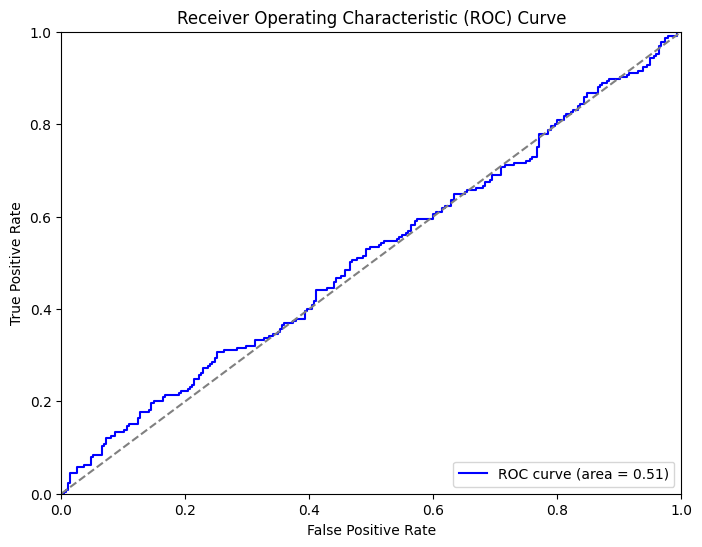

AUC Score: 0.51


In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def evaluate_roc_auc(model, holdout_loader):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for images, labels in holdout_loader:
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Assuming binary classification
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    auc_score = roc_auc_score(all_labels, all_probs)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return auc_score

# Example usage
auc_score = evaluate_roc_auc(final_model, holdout_loader)
print(f'AUC Score: {auc_score:.2f}')


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler

# Load your dataset
data = pd.read_csv('pseudodata_præoperation.csv')

# Preprocess your data
X = data
y = np.random.choice([0, 1], size=len(data))

X = StandardScaler().fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Create a dataset
dataset = TensorDataset(X_tensor, y_tensor)

# Split data into holdout set and remaining set
indices = np.arange(len(dataset))
np.random.seed(42)
np.random.shuffle(indices)
holdout_indices = indices[:500]
remaining_indices = indices[500:]

holdout_set = Subset(dataset, holdout_indices)
remaining_set = Subset(dataset, remaining_indices)

# Define the ANN model
class DeepANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(DeepANNModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_layers = nn.ModuleList([
            nn.Linear(input_dim if i == 0 else hidden_dims[i-1], hidden_dim)
            for i, hidden_dim in enumerate(hidden_dims)
        ])
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        for layer in self.hidden_layers:
            x = self.relu(layer(x))
        x = self.sigmoid(self.output_layer(x))
        return x

# Function to train and evaluate the model with L2 regularization
def train_and_evaluate_model(train_loader, val_loader, input_dim, hidden_dims, output_dim, num_epochs=10, lr=0.01, weight_decay=1e-5):
    model = DeepANNModel(input_dim, hidden_dims, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    # Evaluate on validation set
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / total
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    
    return accuracy, precision, recall, model

# Function for grid search over different weight_decay values using StratifiedKFold
def grid_search_weight_decay(train_set, outer_kf, inner_kf, input_dim, hidden_dims, output_dim, num_epochs=10, lr=0.01, weight_decay_values=[1e-5, 1e-4, 1e-3]):
    best_weight_decay = None
    best_outer_accuracy = 0
    best_outer_precision = 0
    best_outer_recall = 0
    
    for weight_decay in weight_decay_values:
        print(f'Grid search for weight_decay={weight_decay}')
        outer_accuracies = []
        outer_precisions = []
        outer_recalls = []
        
        for outer_train_index, outer_test_index in outer_kf.split(train_set.dataset.tensors[1][outer_train_index]):
            outer_train_subset = Subset(train_set, outer_train_index)
            outer_test_subset = Subset(train_set, outer_test_index)
            
            inner_accuracies = []
            inner_precisions = []
            inner_recalls = []
            
            for inner_train_index, inner_val_index in inner_kf.split(np.zeros(len(outer_train_index)), train_set.dataset.tensors[1][outer_train_index]):
                inner_train_subset = Subset(outer_train_subset, inner_train_index)
                inner_val_subset = Subset(outer_train_subset, inner_val_index)
                
                train_loader = DataLoader(inner_train_subset, batch_size=64, shuffle=True)
                val_loader = DataLoader(inner_val_subset, batch_size=64, shuffle=False)
                
                accuracy, _, _, _ = train_and_evaluate_model(train_loader, val_loader, input_dim, hidden_dims, output_dim, num_epochs=num_epochs, lr=lr, weight_decay=weight_decay)
                inner_accuracies.append(accuracy)
                print(f'  Inner Fold Accuracy: {accuracy * 100:.2f}%')
            
            mean_inner_accuracy = np.mean(inner_accuracies)
            print(f'  Mean Inner Accuracy: {mean_inner_accuracy * 100:.2f}%')
            
            train_loader = DataLoader(outer_train_subset, batch_size=64, shuffle=True)
            test_loader = DataLoader(outer_test_subset, batch_size=64, shuffle=False)
            
            outer_accuracy, outer_precision, outer_recall, _ = train_and_evaluate_model(train_loader, test_loader, input_dim, hidden_dims, output_dim, num_epochs=num_epochs, lr=lr, weight_decay=weight_decay)
            outer_accuracies.append(outer_accuracy)
            outer_precisions.append(outer_precision)
            outer_recalls.append(outer_recall)
            print(f'  Outer Fold Accuracy: {outer_accuracy * 100:.2f}%')
            print(f'  Outer Fold Precision: {outer_precision * 100:.2f}%')
            print(f'  Outer Fold Recall: {outer_recall * 100:.2f}%')
        
        mean_outer_accuracy = np.mean(outer_accuracies)
        mean_outer_precision = np.mean(outer_precisions)
        mean_outer_recall = np.mean(outer_recalls)
        print(f'Mean Outer Accuracy for weight_decay={weight_decay}: {mean_outer_accuracy * 100:.2f}%')
        print(f'Mean Outer Precision for weight_decay={weight_decay}: {mean_outer_precision * 100:.2f}%')
        print(f'Mean Outer Recall for weight_decay={weight_decay}: {mean_outer_recall * 100:.2f}%')
        
        if mean_outer_accuracy > best_outer_accuracy:
            best_outer_accuracy = mean_outer_accuracy
            best_outer_precision = mean_outer_precision
            best_outer_recall = mean_outer_recall
            best_weight_decay = weight_decay
    
    print(f'Best weight_decay: {best_weight_decay}, Best Mean Outer Accuracy: {best_outer_accuracy * 100:.2f}%')
    print(f'Best Mean Outer Precision: {best_outer_precision * 100:.2f}%')
    print(f'Best Mean Outer Recall: {best_outer_recall * 100:.2f}%')
    return best_weight_decay

# Outer 5-Fold Cross-Validation with StratifiedKFold
outer_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Inner 5-Fold Cross-Validation with StratifiedKFold
inner_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search over different weight_decay values
best_weight_decay = grid_search_weight_decay(remaining_set, outer_kf, inner_kf, input_dim=575, hidden_dims=[128, 64], output_dim=2, num_epochs=10, lr=0.01, weight_decay_values=[1e-5, 1e-4, 1e-3])

print(f'Best weight_decay found: {best_weight_decay}')

# Evaluate the final model on the holdout set with the best weight_decay
final_model = DeepANNModel(input_dim=575, hidden_dims=[128, 64], output_dim=2)
train_loader = DataLoader(remaining_set, batch_size=64, shuffle=True)
holdout_loader = DataLoader(holdout_set, batch_size=64, shuffle=False)

accuracy, precision, recall, _ = train_and_evaluate_model(train_loader, holdout_loader, input_dim=575, hidden_dims=[128, 64], output_dim=2, num_epochs=10, lr=0.01, weight_decay=best_weight_decay)

print(f'Holdout Set Accuracy: {accuracy * 100:.2f}%')
print(f'Holdout Set Precision: {precision * 100:.2f}%')
print(f'Holdout Set Recall: {recall * 100:.2f}%')


Grid search for weight_decay=1e-05


UnboundLocalError: cannot access local variable 'outer_train_index' where it is not associated with a value